In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
import cartopy.feature as cfeature
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
import plot_functions
import calendar
import importlib 
importlib.reload(plot_functions)
from plot_functions import *
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib as mpl
from autoencoder import SobelFilterLayer, SimpleAutoencoder
mpl.rcParams['font.size'] = 14



total cores: 256


2019 1 775
2019 2 700
2019 3 775
2019 4 750
2019 10 775
2019 11 375
2019 12 775
2020 1 775
2020 2 725
2020 3 775
2020 4 750
2020 10 775
2020 11 750
2020 12 775
2021 1 775
2021 2 700
2021 3 775
2021 4 750
2021 10 775
2021 11 750
2021 12 775
2022 1 775
2022 2 700
2022 3 775
2022 4 750
2022 10 475
2022 11 750
2022 12 775
2023 1 775
2023 2 700
2023 3 775
2023 4 750


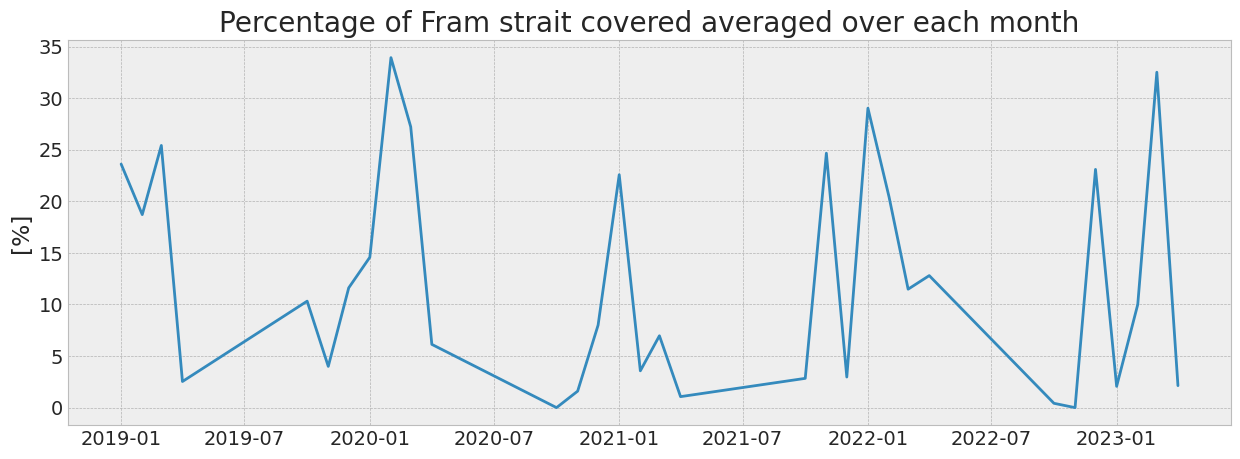

In [71]:
desired_label = [3, 0]
grid_resolution = 128e3
filters = 64
year = 2021
patch_size = 128
projection = ccrs.Stereographic(central_latitude=90)
x_grid, y_grid = generate_xy_grid()
tot_counts = np.zeros_like(x_grid)
tot_days = 0
years = [2019, 2020, 2021, 2022, 2023]
months = [1,2,3,4,10,11,12]
levels = np.linspace(0, 80, 17)
levels_yearly = np.linspace(0, 50, 11)
size_threshold = 7
fram_straight_sum = []
fram_straight_tot = []

for year in years:
    tot_counts_year = np.zeros_like(x_grid)
    tot_days_year = 0
    for month in months:
        if os.path.exists("/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_%s%s.npy"  %(year, int(grid_resolution*1e-3), size_threshold, patch_size, filters, year, str(month).zfill(2))):
            ds = np.load("/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_%s%s.npy" %(year, int(grid_resolution*1e-3), size_threshold, patch_size, filters, year, str(month).zfill(2)), allow_pickle=True).item()
            counts = ds["counts"]
            days = ds["days"]
            tot_days += days    
            tot_counts += counts
            fram_straight_sum.append(np.sum(counts[idxs]))
            fram_straight_tot.append(len(counts[idxs])*days)

            print(year, month, len(counts[idxs])*days)
            tot_days_year += days    
            tot_counts_year += counts
            full_dir = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/" %(size_threshold)
            monthly_dir = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/monthly/" %(size_threshold)
            monthly_avg_dir = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/monthly_averaged/" %(size_threshold)
            yearly_dir = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/yearly/" %(size_threshold)
            if not os.path.exists(full_dir):
                os.makedirs(full_dir)
            if not os.path.exists(monthly_dir):
                os.makedirs(monthly_dir)
            if not os.path.exists(monthly_avg_dir):
                os.makedirs(monthly_avg_dir)
            if not os.path.exists(yearly_dir):
                os.makedirs(yearly_dir)
#             fig, ax = plot_hist_map(x_grid, y_grid, counts, days, projection, title="Percentage of %s %s with predicted CAO" %(calendar.month_name[month][:3], year), extent=[-36, 36, 58.2, 82], levels=levels, cmap="turbo")
#             fig.savefig("/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/monthly/hist_map_%s%s_thr%s.jpg" %(size_threshold, year, str(month).zfill(2), size_threshold))
#             plt.close()

#     fig, ax = plot_hist_map(x_grid, y_grid, tot_counts_year, tot_days_year, projection, title="Percentage of %s with predicted CAO" %(year), extent=[-36, 36, 58.2, 82], levels=levels_yearly, cmap="turbo")
#     fig.savefig("/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/yearly/hist_map_%s_cao_months_thr%s.jpg" %(size_threshold, year, size_threshold))
#     plt.close()

# fig, ax = plot_hist_map(x_grid, y_grid, tot_counts, tot_days, projection, title="Percentage of %s-%s with predicted CAO" %(years[0], years[-1]), extent=[-36, 36, 58.2, 82], levels=levels_yearly, cmap="turbo")
# fig.savefig("/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/hist_map_%s-%s_cao_months_thr%s.jpg" %(size_threshold, years[0], years[-1], size_threshold))
# plt.close()

x_grid, y_grid = generate_xy_grid()
projection = ccrs.PlateCarree()
lon_grid, lat_grid = projection.transform_points(ccrs.NorthPolarStereo(), x_grid, y_grid)[:, :, :2].T

idxs = np.where((lon_grid < 15) & (lon_grid > -15) & (lat_grid > 75) & (lat_grid < 80))
from itertools import product
all_dates = [datetime.datetime(year, month, 1) for year, month in product(years, months)]

plt.figure(figsize=[15, 5])
plt.title("Percentage of time with any predicted CAO inside Fram strait")
plt.ylabel("[%]")
plt.plot(all_dates[:-3], np.array(fram_straight_sum)/np.array(fram_straight_tot)*100)


In [5]:
import calendar
importlib.reload(plot_functions)
from plot_functions import *
levels = np.linspace(0, 60, 13)

for month in months:
    tot_counts = np.zeros_like(x_grid)
    tot_days = 0
    for year in years:
        print(year)
        if os.path.exists("/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_%s%s.npy"  %(year, int(grid_resolution*1e-3), 3, patch_size, filters, year, str(month).zfill(2))):
            ds = np.load("/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_%s%s.npy" %(year, int(grid_resolution*1e-3), 3, patch_size, filters, year, str(month).zfill(2)), allow_pickle=True).item()
            counts = ds["counts"]
            days = ds["days"]
            tot_days += days    
            tot_counts += counts
    print(tot_days)
    fig, ax = plot_hist_map(x_grid, y_grid, tot_counts, tot_days, projection, title="Percentage of %s with predicted CAO" %(calendar.month_name[month]), extent=[-36, 36, 58.2, 82], levels=levels, cmap="turbo")
    fig.tight_layout()
    fig.savefig("/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/monthly_averaged/hist_map_%s-%s_%s_thr%s.jpg" %(size_threshold, years[0], years[-1], calendar.month_name[month][:3], size_threshold))
    plt.close()

2023
31


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'set_under'
  result = super().contourf(*args, **kwargs)


2023
28


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'set_under'
  result = super().contourf(*args, **kwargs)


2023
31


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'set_under'
  result = super().contourf(*args, **kwargs)


2023
30


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'set_under'
  result = super().contourf(*args, **kwargs)


In [21]:
import imageio
import os 
size_threshold = 

file_struc = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/monthly_averaged/hist_map_2019-2023_" %(size_threshold)
months = [10,11,12,1,2,3,4]
output_gif_path = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/animations/hist_map_2019-2023_monthly_averaged_animation_thr%s.gif" %(size_threshold)
with imageio.get_writer(output_gif_path, duration=2000, loop=0) as writer:
    for month in months:
        image = imageio.imread(file_struc +  calendar.month_name[month][:3]  + "_thr%s" %(size_threshold) + ".jpg")
        writer.append_data(image)

/tmp/ipykernel_839167/1670032480.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_struc +  calendar.month_name[month][:3]  + "_thr%s" %(size_threshold) + ".jpg")


FileNotFoundError: No such file: '/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr3/monthly_averaged/hist_map_2019-2023_Oct_thr3.jpg'

In [23]:
file_struc = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/monthly/hist_map_" %(size_threshold)
months = [1,2,3,4,10,11,12]
years = [2019, 2020, 2021, 2022, 2023]
output_gif_path = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/animations/hist_map_2019-2023_monthly_animation_thr%s.gif" %(size_threshold)

with imageio.get_writer(output_gif_path, duration=1000, loop=0) as writer:
    for year in years:
        for month in months:
            image = imageio.imread(file_struc + str(year) + str(month).zfill(2) + "_thr%s" %(size_threshold) + ".jpg")
            writer.append_data(image)

/tmp/ipykernel_839167/3632970928.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_struc + str(year) + str(month).zfill(2) + "_thr%s" %(size_threshold) + ".jpg")


FileNotFoundError: No such file: '/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr3/monthly/hist_map_201901_thr3.jpg'

In [24]:
size_threshold = 5

file_struc = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr%s/yearly/hist_map_" %(size_threshold)
months = [1,2,3,4,10,11,12]
years = [2019, 2020, 2021, 2022, 2023]
output_gif_path = "/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/animations/hist_map_2019-2023_yearly_animation_thr%s.gif" %(size_threshold)

with imageio.get_writer(output_gif_path, duration=1000, loop=0) as writer:
    for year in years:
        image = imageio.imread(file_struc + str(year) + "_cao_months" + "_thr%s" %(size_threshold) + ".jpg")
        writer.append_data(image)

/tmp/ipykernel_839167/3735946173.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_struc + str(year) + "_cao_months" + "_thr%s" %(size_threshold) + ".jpg")
